In [2]:
!pip install opendatasets --quiet
import opendatasets as od

od.download("https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mohamedismail11
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset


100%|██████████| 219M/219M [00:00<00:00, 1.04GB/s]


In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
import warnings
warnings.filterwarnings('ignore')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [9]:
# 📁 Path to the dataset folder
dataset_path = './rice-image-dataset/Rice_Image_Dataset'

# 🔹 Create empty lists to store image paths and labels
images = []
labels = []

# 🔹 Loop through each subfolder (each rice type)
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)

    # Skip if it's not a folder
    if not os.path.isdir(subfolder_path):
        continue

    # 🔹 Loop through the images inside the subfolder
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)

        # Check if it's an image file (ends with .jpg, .jpeg, .png)
        if image_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            images.append(image_path)
            labels.append(subfolder)

# 🔹 Create a DataFrame with image paths and labels
df = pd.DataFrame({'image': images, 'label': labels})

print(f"✅ DataFrame created with {len(df)} images")
print(df.head())


✅ DataFrame created with 75000 images
                                               image    label
0  ./rice-image-dataset/Rice_Image_Dataset/Basmat...  Basmati
1  ./rice-image-dataset/Rice_Image_Dataset/Basmat...  Basmati
2  ./rice-image-dataset/Rice_Image_Dataset/Basmat...  Basmati
3  ./rice-image-dataset/Rice_Image_Dataset/Basmat...  Basmati
4  ./rice-image-dataset/Rice_Image_Dataset/Basmat...  Basmati


In [10]:
df.head()

,image,label
0,./rice-image-dataset/Rice_Image_Dataset/Basmat...,Basmati
1,./rice-image-dataset/Rice_Image_Dataset/Basmat...,Basmati
2,./rice-image-dataset/Rice_Image_Dataset/Basmat...,Basmati
3,./rice-image-dataset/Rice_Image_Dataset/Basmat...,Basmati
4,./rice-image-dataset/Rice_Image_Dataset/Basmat...,Basmati


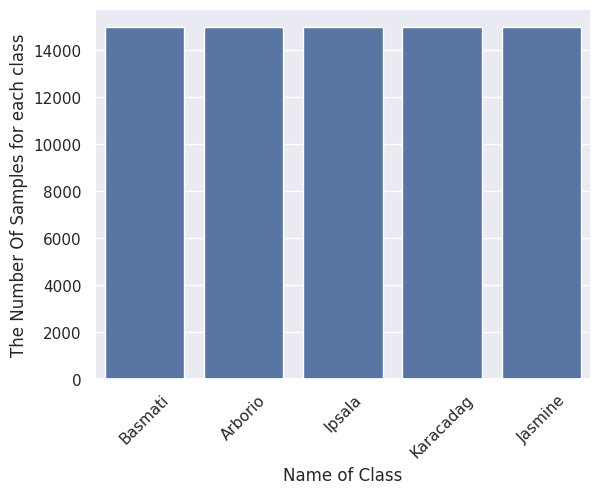

In [11]:
# plot the classes
ax = sns.countplot(x=df.label)

# Set labels and titles
ax.set_xlabel("Name of Class")
ax.set_ylabel("The Number Of Samples for each class")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

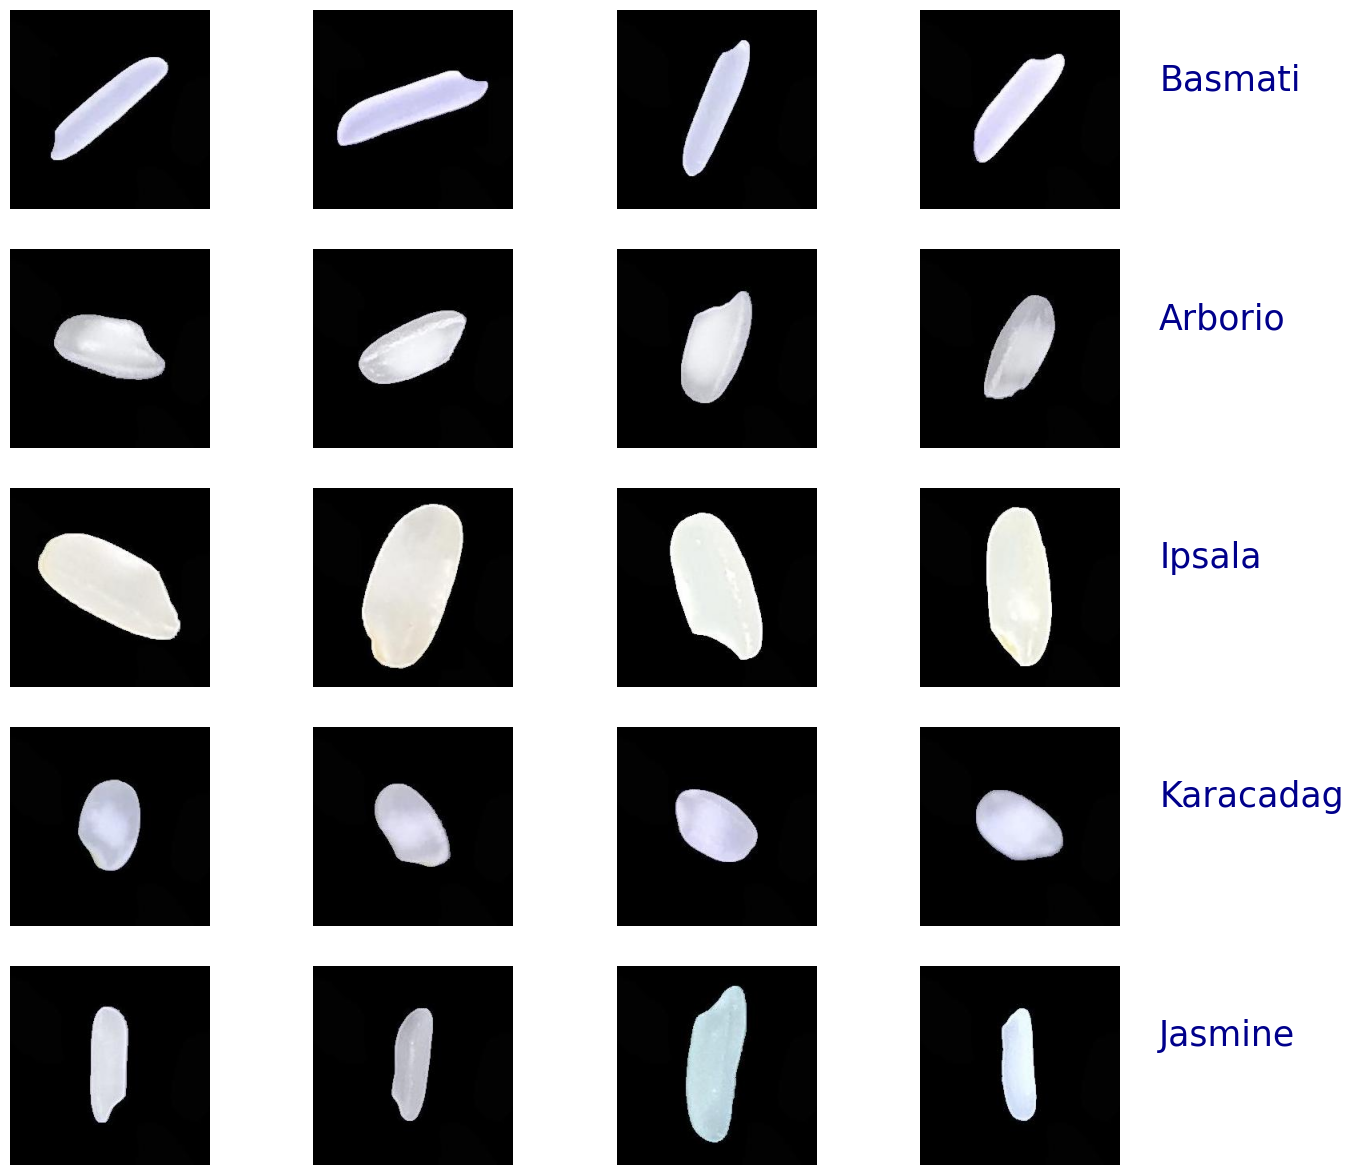

In [12]:
from matplotlib.gridspec import GridSpec
# Create figure and grid of subplots
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

# Loop through each unique category in the DataFrame
for i, category in enumerate(df['label'].unique()):
    # Get the filepaths for the first four images in the category
    filepaths = df[df['label'] == category]['image'].values[:4]

    # Loop through the filepaths and add an image to each subplot
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')

    # Add a label to the bottom of the subplot grid
    ax.text(300, 100, category, fontsize=25, color='darkblue')

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42)

# Create a dataframe for the training data
df_train = pd.DataFrame({'image': X_train, 'label': y_train})

# Create a dataframe for the test data
df_test = pd.DataFrame({'image': X_test, 'label': y_test})

# Encode the labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the image size and batch size
image_size = (50, 50)
batch_size = 32

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the test data
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 60000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.


In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Set the input shape for the model
input_shape = (50, 50, 3)

# Create a Sequential model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [18]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# Train the model on the training data
history = model.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 124s 63ms/step - accuracy: 0.7776 - loss: 0.5464 - val_accuracy: 0.9475 - val_loss: 0.1520
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 111s 59ms/step - accuracy: 0.9384 - loss: 0.1730 - val_accuracy: 0.9525 - val_loss: 0.1304
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 112s 60ms/step - accuracy: 0.9614 - loss: 0.1115 - val_accuracy: 0.9659 - val_loss: 0.0927
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 112s 60ms/step - accuracy: 0.9643 - loss: 0.0971 - val_accuracy: 0.9723 - val_loss: 0.0801
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 108s 58ms/step - accuracy: 0.9740 - loss: 0.0746 - val_accuracy: 0.9819 - val_loss: 0.0520


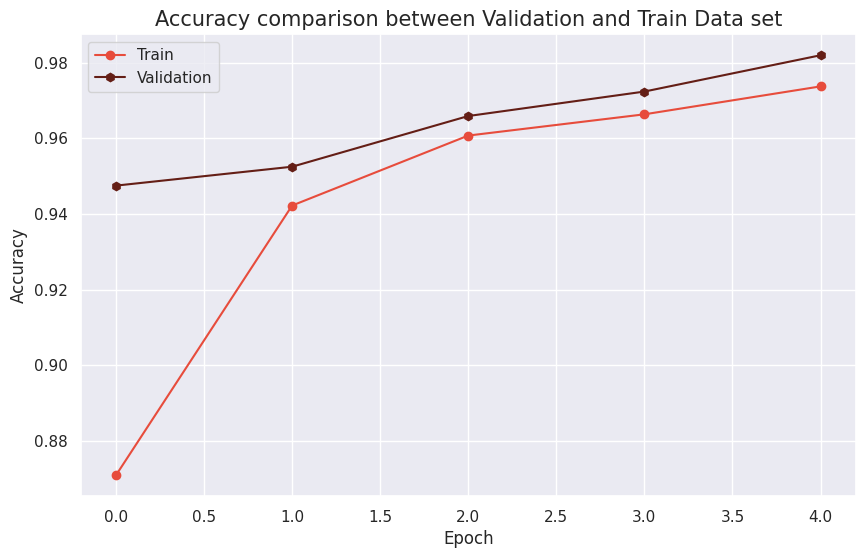

In [26]:
#Accuracy comparison between Validation and Train Data set
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Accuracy comparison between Validation and Train Data set', fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()


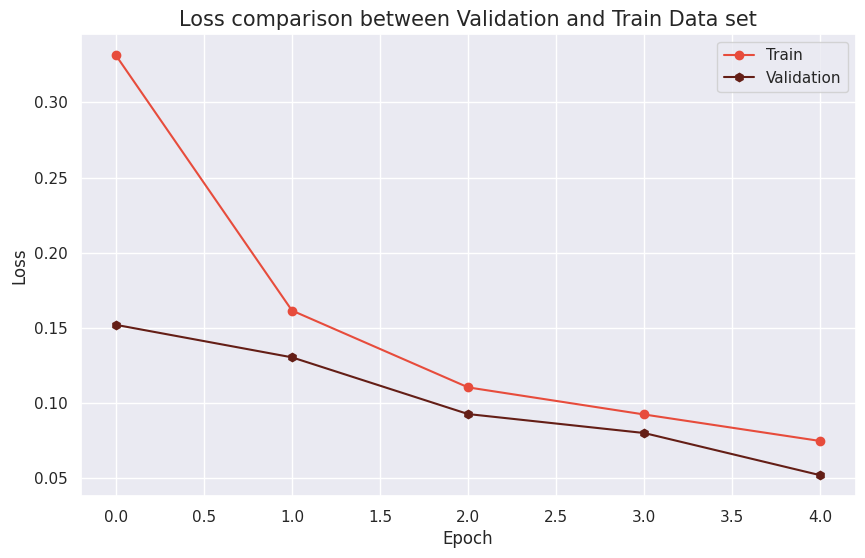

In [25]:
#Loss comparison between Validation and Train Data set
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color="#E74C3C", marker='o')
plt.plot(history.history['val_loss'], color='#641E16', marker='h')
plt.title('Loss comparison between Validation and Train Data set', fontsize=15)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()


In [27]:
# Evaluate the model on the test data
metrics = model.evaluate(test_generator)
# Print the accuracy of the model
print('Accuracy:', metrics[1])

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.9844 - loss: 0.0446
Accuracy: 0.9833333492279053


469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step


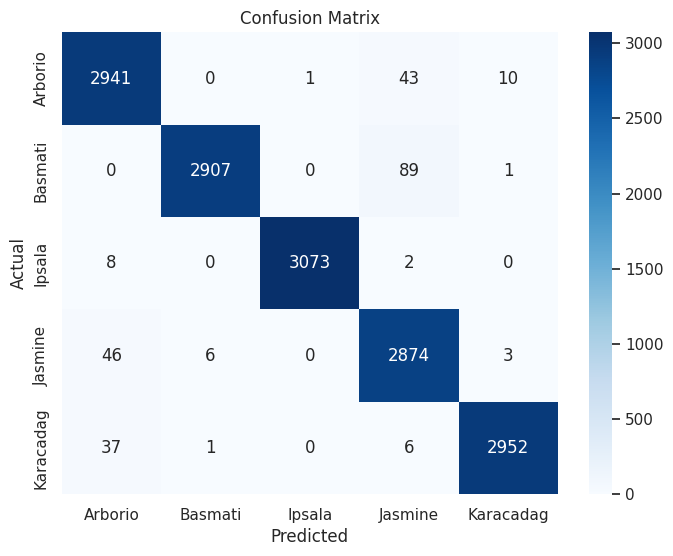

              precision    recall  f1-score   support

     Arborio       0.97      0.98      0.98      2995
     Basmati       1.00      0.97      0.98      2997
      Ipsala       1.00      1.00      1.00      3083
     Jasmine       0.95      0.98      0.97      2929
   Karacadag       1.00      0.99      0.99      2996

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



In [30]:
# Get predictions for the test data
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get the true labels
y_true = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=cm_labels, yticklabels=cm_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=cm_labels))


In [33]:
# Save weights only
torch.save(model.state_dict(), 'cnn_model_weights.pth')

# Load weights into a new model instance
loaded_model = MyCNNModel()
loaded_model.load_state_dict(torch.load('cnn_model_weights.pth'))
loaded_model.eval()
print("Model loaded successfully with weights!")


Model loaded successfully with weights!
